In [1]:
using CSV; using DataFrames; ENV["COLUMNS"]=160
using Interpolations
using Plots; pyplot(); default(framestyle = :box, minorticks = 5, size=(500,350));
using QuadGK; using LaTeXStrings
# using BenchmarkTools
using IMinuit

In [2]:
include("hadronmasses.jl")
include("quadgauss.jl")
include("omnes.jl");

In [3]:
const C1=0.2005;
const C2=-0.0657;

In [4]:
# region for the dispersive integration 
const xw64, ww64 = gauss(128, 2mπ+0.000001, 5.0)
# region for the Fourier transform inegration
const xft96, wft96 = gauss(96, 0, 20.);

In [5]:
σ(s, m) = sqrt(1 - 4m^2/s)
λ(x, y, z) = x^2 + y^2 + z^2 -2x*y - 2y*z - 2z*x
q3(s) = sqrt(λ(mψp^2, mjψ^2, s))/(2mψp)

# here only consider the S-wave part, par = [c1, c2]
function amp0(s, par;which=:BO)
    c1, c2 = par
    msq = mψp^2; mpisq = mπ^2
    qsq = λ(msq, mjψ^2, s)/(4msq)
    σsq = 1 - 4mpisq/s
    return -2/fπ^2 * (c1 * (s-2mpisq) + 0.5c2 * (s + qsq * (1 - σsq/3)) ) * absomnes(sqrt(s),which=which)*sqrt(3/2)
end

amp0 (generic function with 1 method)

## Gaussian FF $e^{-q^2/\Lambda^2}$

In [9]:
# Fourier transform 
function ft(μ, r, Λ = 0.0)
    if Λ ≈ 0.0
        R = 0.8 /hbarc
        res = exp(-μ*r)/(4π*r) 
    else
        function inte(q) 
            return q*sin(q*r)/(μ^2+q^2) * exp(-q^2/Λ^2)
        end
        res = quadgauss(inte, xft96, wft96) / (2π^2*r)
    end
    return res
end


# in units of MeV
function vσs(r, par, Λ = 0.0,tmax=5.0;which=:BO)
    function vintegrand(w)
        s = w^2
        sqrt(s-4mπ^2) * (amp0(s, par,which=which))^2 * ft(w, r, Λ)
    end
    xx, ww = gauss(128*2, 2mπ+0.000001, tmax)
    res = -1/(8π^2)/(4mψp*mjψ) *  quadgauss(vintegrand, xx, ww) 
    return res * 1e3
end

vσs (generic function with 3 methods)

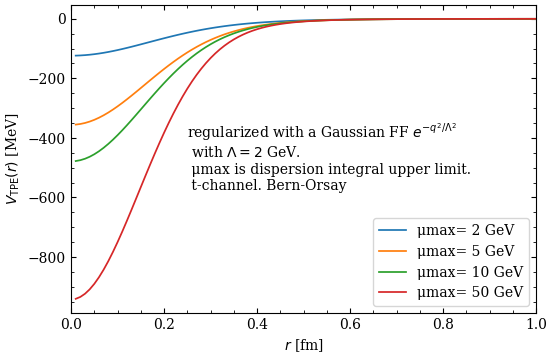

  3.876939 seconds (3.62 M allocations: 346.950 MiB, 2.47% gc time)


In [10]:
function plt_vσ(par1; rlow = 0.4)
    rfmv = rlow:0.01:1
    PyPlot.subplots(figsize=(6,4))
    PyPlot.grid(which="major", axis="both", alpha=0.25)
    PyPlot.plot(rfmv, vσs.(rfmv ./hbarc, Ref(par1),2,2.0), label = "μmax= 2 GeV")
    PyPlot.plot(rfmv, vσs.(rfmv ./hbarc, Ref(par1),2,5.0), label = "μmax= 5 GeV")
    PyPlot.plot(rfmv, vσs.(rfmv ./hbarc, Ref(par1),2,10.0), label = "μmax= 10 GeV")
    PyPlot.plot(rfmv, vσs.(rfmv ./hbarc, Ref(par1),2,50.0), label = "μmax= 50 GeV")
    PyPlot.annotate("regularized with a Gaussian FF "*L"e^{-q^2/\Lambda^2}"*"\n with "*L"\Lambda=2"*
        " GeV.\n μmax is dispersion integral upper limit.\n t-channel. Bern-Orsay",
        xy = (0.25,0.4),xycoords = "axes fraction")
    PyPlot.xlabel(L"r"*" [fm]"); PyPlot.ylabel(L"V_{\rm TPE}(r)"*" [MeV]")
    PyPlot.legend()
    PyPlot.minorticks_on(); PyPlot.tick_params(which="both",direction="in", right="on", top="on") 
    
    PyPlot.xlim(rfmv[1], rfmv[end]);
    PyPlot.savefig("potentials/Gau1-mu-var.pdf");
end
@time plt_vσ([C1,C2], rlow = 0)

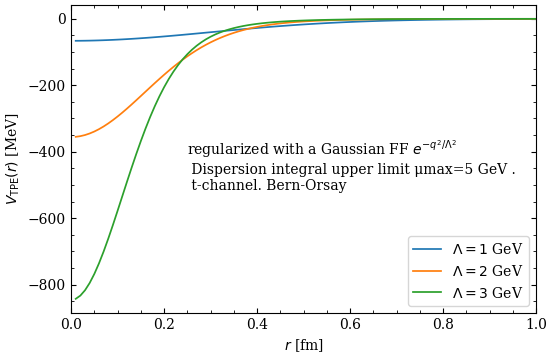

  2.352241 seconds (1.25 M allocations: 185.094 MiB, 1.82% gc time)


In [11]:
function plt_vσ(par1; rlow = 0.4)
    rfmv = rlow:0.01:1
    PyPlot.subplots(figsize=(6,4))
    PyPlot.grid(which="major", axis="both", alpha=0.25)
    PyPlot.plot(rfmv, vσs.(rfmv ./hbarc, Ref(par1),1,5.0), label = L"\Lambda = 1"*" GeV")
    PyPlot.plot(rfmv, vσs.(rfmv ./hbarc, Ref(par1),2,5.0), label = L"\Lambda = 2"*" GeV")
    PyPlot.plot(rfmv, vσs.(rfmv ./hbarc, Ref(par1),3,5.0), label = L"\Lambda = 3"*" GeV")
    PyPlot.annotate("regularized with a Gaussian FF "*L"e^{-q^2/\Lambda^2}"*
        "\n Dispersion integral upper limit μmax=5 GeV .\n t-channel. Bern-Orsay",
        xy = (0.25,0.4),xycoords = "axes fraction")
    PyPlot.xlabel(L"r"*" [fm]"); PyPlot.ylabel(L"V_{\rm TPE}(r)"*" [MeV]")
    PyPlot.legend()
    PyPlot.minorticks_on(); PyPlot.tick_params(which="both",direction="in", right="on", top="on") 
    
    PyPlot.xlim(rfmv[1], rfmv[end]);
    
    PyPlot.savefig("potentials/Gau1-Lambda-var.pdf");
end
@time plt_vσ([C1,C2], rlow = 0)

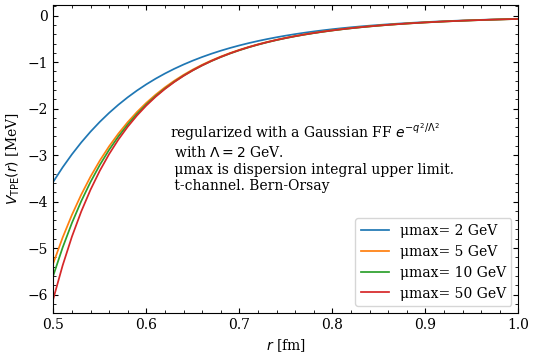

  1.677348 seconds (55.69 k allocations: 112.666 MiB, 1.20% gc time)


In [9]:
function plt_vσ(par1; rlow = 0.4)
    rfmv = rlow:0.01:1.0
    PyPlot.subplots(figsize=(6,4))
    PyPlot.grid(which="major", axis="both", alpha=0.25)
    PyPlot.plot(rfmv, vσs.(rfmv ./hbarc, Ref(par1),2,2.0), label = "μmax= 2 GeV")
    PyPlot.plot(rfmv, vσs.(rfmv ./hbarc, Ref(par1),2,5.0), label = "μmax= 5 GeV")
    PyPlot.plot(rfmv, vσs.(rfmv ./hbarc, Ref(par1),2,10.0), label = "μmax= 10 GeV")
    PyPlot.plot(rfmv, vσs.(rfmv ./hbarc, Ref(par1),2,50.0), label = "μmax= 50 GeV")
    PyPlot.annotate("regularized with a Gaussian FF "*L"e^{-q^2/\Lambda^2}"*"\n with "*L"\Lambda=2"*
        " GeV.\n μmax is dispersion integral upper limit.\n t-channel. Bern-Orsay",
        xy = (0.25,0.4),xycoords = "axes fraction")
    PyPlot.xlabel(L"r"*" [fm]"); PyPlot.ylabel(L"V_{\rm TPE}(r)"*" [MeV]")
    PyPlot.legend()
    PyPlot.minorticks_on(); PyPlot.tick_params(which="both",direction="in", right="on", top="on") 
    
    PyPlot.xlim(rfmv[1], rfmv[end]);
    PyPlot.savefig("potentials/Gau1-mu-var-med.pdf");
end
@time plt_vσ([C1,C2], rlow =0.5)

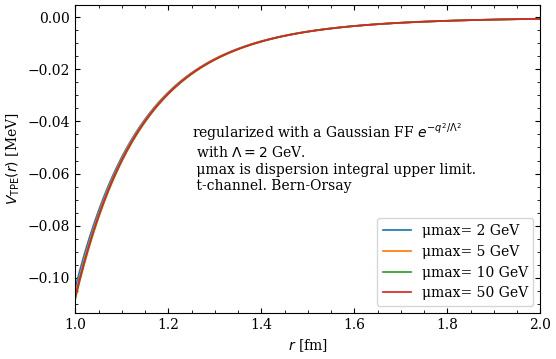

  2.717223 seconds (1.67 M allocations: 246.786 MiB, 1.56% gc time)


In [12]:
function plt_vσ(par1; rlow = 0.4)
    rfmv = rlow:0.01:2.0
    PyPlot.subplots(figsize=(6,4))
    PyPlot.grid(which="major", axis="both", alpha=0.25)
    PyPlot.plot(rfmv, vσs.(rfmv ./hbarc, Ref(par1),2,2.0), label = "μmax= 2 GeV")
    PyPlot.plot(rfmv, vσs.(rfmv ./hbarc, Ref(par1),2,5.0), label = "μmax= 5 GeV")
    PyPlot.plot(rfmv, vσs.(rfmv ./hbarc, Ref(par1),2,10.0), label = "μmax= 10 GeV")
    PyPlot.plot(rfmv, vσs.(rfmv ./hbarc, Ref(par1),2,50.0), label = "μmax= 50 GeV")
    PyPlot.annotate("regularized with a Gaussian FF "*L"e^{-q^2/\Lambda^2}"*"\n with "*L"\Lambda=2"*
        " GeV.\n μmax is dispersion integral upper limit.\n t-channel. Bern-Orsay",
        xy = (0.25,0.4),xycoords = "axes fraction")
    PyPlot.xlabel(L"r"*" [fm]"); PyPlot.ylabel(L"V_{\rm TPE}(r)"*" [MeV]")
    PyPlot.legend()
    PyPlot.minorticks_on(); PyPlot.tick_params(which="both",direction="in", right="on", top="on") 
    
    PyPlot.xlim(rfmv[1], rfmv[end]);
    PyPlot.savefig("potentials/Gau1-mu-var-long.pdf");
end
@time plt_vσ([C1,C2], rlow =1.0)

## Modified Gaussian FF $e^{-(q^2+\mu^2)/\Lambda^2}$

In [7]:
# Fourier transform 
function ftGau1(μ, r,a, Λ = 0.0)
    if Λ ≈ 0.0
        R = 0.8 /hbarc
        res = exp(-μ*r)/(4π*r) 
    else
        function inte(q) 
            return q*sin(q*r)/(μ^2+q^2) * exp(-(q^2+μ^2)^a/Λ^(2a))
        end
        res = quadgauss(inte, xft96, wft96) / (2π^2*r)
    end
    return res
end


# in units of MeV
function vσGau1s(r, par, a = 1.0, Λ = 0.0,tmax=5.0;which=:BO)
    function vintegrand(w)
        s = w^2
        sqrt(s-4mπ^2) * (amp0(s, par,which=which))^2 * ftGau1(w, r, a, Λ)
    end
    xx, ww = gauss(128*2, 2mπ+0.000001, tmax)
    res = -1/(8π^2)/(4mψp*mjψ) *  quadgauss(vintegrand, xx, ww) 
    return res * 1e3
end

vσGau1s (generic function with 4 methods)

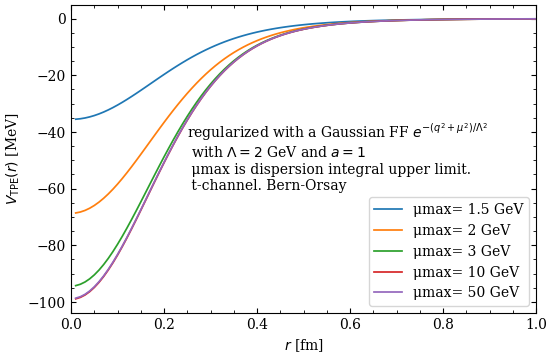

  3.551847 seconds (135.55 k allocations: 278.780 MiB, 1.67% gc time)


In [23]:
function plt_vσ(par1; rlow = 0.4)
    rfmv = rlow:0.01:1
    PyPlot.subplots(figsize=(6,4))
    PyPlot.grid(which="major", axis="both", alpha=0.25)
    PyPlot.plot(rfmv, vσGau1s.(rfmv ./hbarc, Ref(par1),1,2,1.5), label = "μmax= 1.5 GeV")
    PyPlot.plot(rfmv, vσGau1s.(rfmv ./hbarc, Ref(par1),1,2,2.0), label = "μmax= 2 GeV")
    PyPlot.plot(rfmv, vσGau1s.(rfmv ./hbarc, Ref(par1),1,2,3.0), label = "μmax= 3 GeV")
    PyPlot.plot(rfmv, vσGau1s.(rfmv ./hbarc, Ref(par1),1,2,10.0), label = "μmax= 10 GeV")
    PyPlot.plot(rfmv, vσGau1s.(rfmv ./hbarc, Ref(par1),1,2,50.0), label = "μmax= 50 GeV")
    PyPlot.annotate("regularized with a Gaussian FF "*L"e^{-(q^2+μ^2)/\Lambda^2}"*"\n with "*L"\Lambda=2"*" GeV and "*L"a=1."*
        "\n μmax is dispersion integral upper limit.\n t-channel. Bern-Orsay",
        xy = (0.25,0.4),xycoords = "axes fraction")
    PyPlot.xlabel(L"r"*" [fm]"); PyPlot.ylabel(L"V_{\rm TPE}(r)"*" [MeV]")
    PyPlot.legend()
    PyPlot.minorticks_on(); PyPlot.tick_params(which="both",direction="in", right="on", top="on") 
    
    PyPlot.xlim(rfmv[1], rfmv[end]);
    PyPlot.savefig("potentials/Gau2-mu-var.pdf");
end
@time plt_vσ([C1,C2], rlow = 0)

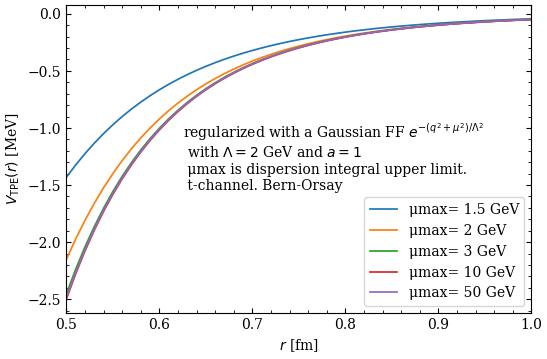

  3.272748 seconds (1.45 M allocations: 212.851 MiB, 1.89% gc time)


In [7]:
function plt_vσ(par1; rlow = 0.4)
    rfmv = rlow:0.01:1
    PyPlot.subplots(figsize=(6,4))
    PyPlot.grid(which="major", axis="both", alpha=0.25)
    PyPlot.plot(rfmv, vσGau1s.(rfmv ./hbarc, Ref(par1),1,2,1.5), label = "μmax= 1.5 GeV")
    PyPlot.plot(rfmv, vσGau1s.(rfmv ./hbarc, Ref(par1),1,2,2.0), label = "μmax= 2 GeV")
    PyPlot.plot(rfmv, vσGau1s.(rfmv ./hbarc, Ref(par1),1,2,3.0), label = "μmax= 3 GeV")
    PyPlot.plot(rfmv, vσGau1s.(rfmv ./hbarc, Ref(par1),1,2,10.0), label = "μmax= 10 GeV")
    PyPlot.plot(rfmv, vσGau1s.(rfmv ./hbarc, Ref(par1),1,2,50.0), label = "μmax= 50 GeV")
    PyPlot.annotate("regularized with a Gaussian FF "*L"e^{-(q^2+μ^2)/\Lambda^2}"*"\n with "*L"\Lambda=2"*" GeV and "*L"a=1."*
        "\n μmax is dispersion integral upper limit.\n t-channel. Bern-Orsay",
        xy = (0.25,0.4),xycoords = "axes fraction")
    PyPlot.xlabel(L"r"*" [fm]"); PyPlot.ylabel(L"V_{\rm TPE}(r)"*" [MeV]")
    PyPlot.legend()
    PyPlot.minorticks_on(); PyPlot.tick_params(which="both",direction="in", right="on", top="on") 
    
    PyPlot.xlim(rfmv[1], rfmv[end]);
    PyPlot.savefig("potentials/Gau2-mu-var-med.pdf");
end
@time plt_vσ([C1,C2], rlow = 0.5)

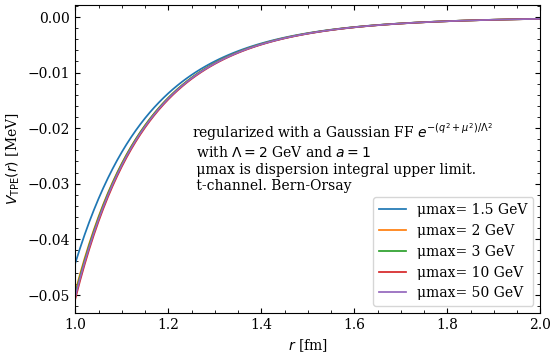

  3.327833 seconds (135.55 k allocations: 278.780 MiB, 1.52% gc time)


In [8]:
function plt_vσ(par1; rlow = 0.4)
    rfmv = rlow:0.01:2
    PyPlot.subplots(figsize=(6,4))
    PyPlot.grid(which="major", axis="both", alpha=0.25)
    PyPlot.plot(rfmv, vσGau1s.(rfmv ./hbarc, Ref(par1),1,2,1.5), label = "μmax= 1.5 GeV")
    PyPlot.plot(rfmv, vσGau1s.(rfmv ./hbarc, Ref(par1),1,2,2.0), label = "μmax= 2 GeV")
    PyPlot.plot(rfmv, vσGau1s.(rfmv ./hbarc, Ref(par1),1,2,3.0), label = "μmax= 3 GeV")
    PyPlot.plot(rfmv, vσGau1s.(rfmv ./hbarc, Ref(par1),1,2,10.0), label = "μmax= 10 GeV")
    PyPlot.plot(rfmv, vσGau1s.(rfmv ./hbarc, Ref(par1),1,2,50.0), label = "μmax= 50 GeV")
    PyPlot.annotate("regularized with a Gaussian FF "*L"e^{-(q^2+μ^2)/\Lambda^2}"*"\n with "*L"\Lambda=2"*" GeV and "*L"a=1."*
        "\n μmax is dispersion integral upper limit.\n t-channel. Bern-Orsay",
        xy = (0.25,0.4),xycoords = "axes fraction")
    PyPlot.xlabel(L"r"*" [fm]"); PyPlot.ylabel(L"V_{\rm TPE}(r)"*" [MeV]")
    PyPlot.legend()
    PyPlot.minorticks_on(); PyPlot.tick_params(which="both",direction="in", right="on", top="on") 
    
    PyPlot.xlim(rfmv[1], rfmv[end]);
    PyPlot.savefig("potentials/Gau2-mu-var-long.pdf");
end
@time plt_vσ([C1,C2], rlow = 1)

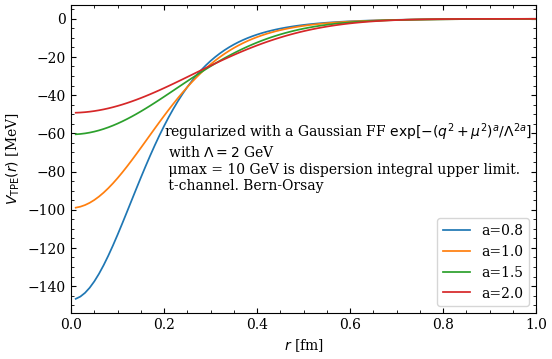

  4.273107 seconds (1.72 M allocations: 249.534 MiB, 1.68% gc time)


In [14]:
function plt_vσ(par1; rlow = 0.4)
    rfmv = rlow:0.01:1
    PyPlot.subplots(figsize=(6,4))
    PyPlot.grid(which="major", axis="both", alpha=0.25)
    PyPlot.plot(rfmv, vσGau1s.(rfmv ./hbarc, Ref(par1),0.8,2,10), label = "a=0.8")
    PyPlot.plot(rfmv, vσGau1s.(rfmv ./hbarc, Ref(par1),1.0,2,10.0), label = "a=1.0")
    PyPlot.plot(rfmv, vσGau1s.(rfmv ./hbarc, Ref(par1),1.5,2,10.0), label = "a=1.5")
    PyPlot.plot(rfmv, vσGau1s.(rfmv ./hbarc, Ref(par1),2.0,2,10.0), label = "a=2.0")
    PyPlot.annotate("regularized with a Gaussian FF "*L"\exp[{-(q^2+μ^2)^a/\Lambda^{2a}}]"*"\n with "*L"\Lambda=2"*" GeV"*
        "\n μmax = 10 GeV is dispersion integral upper limit.\n t-channel. Bern-Orsay",
        xy = (0.2,0.4),xycoords = "axes fraction")
    PyPlot.xlabel(L"r"*" [fm]"); PyPlot.ylabel(L"V_{\rm TPE}(r)"*" [MeV]")
    PyPlot.legend()
    PyPlot.minorticks_on(); PyPlot.tick_params(which="both",direction="in", right="on", top="on") 
    
    PyPlot.xlim(rfmv[1], rfmv[end]);
    PyPlot.savefig("potentials/Gau2-a-var.pdf");
end
@time plt_vσ([C1,C2], rlow = 0)

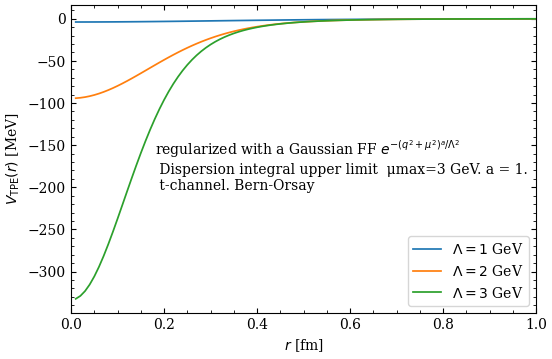

  2.555291 seconds (1.28 M allocations: 186.451 MiB, 1.42% gc time)


In [15]:
function plt_vσ(par1; rlow = 0.4)
    rfmv = rlow:0.01:1
    PyPlot.subplots(figsize=(6,4))
    PyPlot.grid(which="major", axis="both", alpha=0.25)
    PyPlot.plot(rfmv, vσGau1s.(rfmv ./hbarc, Ref(par1),1,1,3.0), label = L"\Lambda = 1"*" GeV")
    PyPlot.plot(rfmv, vσGau1s.(rfmv ./hbarc, Ref(par1),1,2,3.0), label = L"\Lambda = 2"*" GeV")
    PyPlot.plot(rfmv, vσGau1s.(rfmv ./hbarc, Ref(par1),1,3,3.0), label = L"\Lambda = 3"*" GeV")
    PyPlot.annotate("regularized with a Gaussian FF "*L"e^{-(q^2+μ^2)^a/\Lambda^2}"
        *"\n Dispersion integral upper limit  μmax=3 GeV. a = 1.\n t-channel. Bern-Orsay",
        xy = (0.18,0.4),xycoords = "axes fraction")
    PyPlot.xlabel(L"r"*" [fm]"); PyPlot.ylabel(L"V_{\rm TPE}(r)"*" [MeV]")
    PyPlot.legend()
    PyPlot.minorticks_on(); PyPlot.tick_params(which="both",direction="in", right="on", top="on") 
    
    PyPlot.xlim(rfmv[1], rfmv[end]);
    PyPlot.savefig("potentials/Gau2-Lambda-var.pdf");
end
@time plt_vσ([C1,C2], rlow = 0)

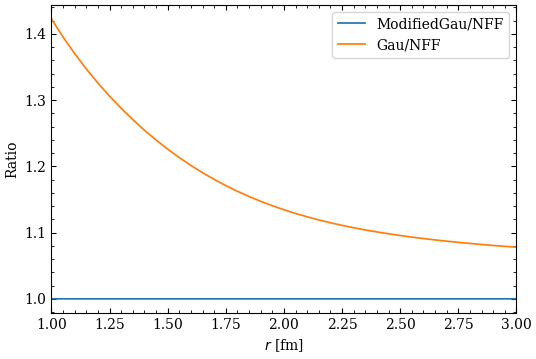

  1.244087 seconds (44.16 k allocations: 90.541 MiB, 2.31% gc time)


In [28]:
function plt_vσ(par1; rlow = 0.4)
    rfmv = rlow:0.05:3
    PyPlot.subplots(figsize=(6,4))
    PyPlot.grid(which="major", axis="both", alpha=0.25)
     PyPlot.plot(rfmv, vσGau1s.(rfmv ./hbarc, Ref(par1),1,2,50)./vσGau1s.(rfmv ./hbarc, Ref(par1),1,0,50), label = "ModifiedGau/NFF")
     PyPlot.plot(rfmv, vσs.(rfmv ./hbarc, Ref(par1),2,50)./vσGau1s.(rfmv ./hbarc, Ref(par1),1,0,50), label = "Gau/NFF")
#      PyPlot.plot(rfmv, vσGau1s.(rfmv ./hbarc, Ref(par1),1,0,50)./vσs.(rfmv ./hbarc, Ref(par1),0,50.0), label = "μmax= 3 GeV")
    
#      PyPlot.plot(rfmv, vσGau1s.(rfmv ./hbarc, Ref(par1),1,2,50), label = "μmax= 1.5 GeV")
#      PyPlot.plot(rfmv, vσGau1s.(rfmv ./hbarc, Ref(par1),1,0,50), label = "μmax= 1.5 GeV")
    PyPlot.xlabel(L"r"*" [fm]"); PyPlot.ylabel("Ratio")
    PyPlot.legend()
    PyPlot.minorticks_on(); PyPlot.tick_params(which="both",direction="in", right="on", top="on") 
    
    PyPlot.xlim(rfmv[1], rfmv[end]);
    PyPlot.savefig("potentials/Gaucompare.pdf");
end
@time plt_vσ([C1,C2], rlow = 1.0)

In [27]:
1/exp(-138^2/450^2)

1.0986085718797833

## Dipole FF $\frac{(\Lambda+\mu)^2-\mu^2}{(\Lambda+\mu)^2-q^2}$ at each vertex

In [16]:
# Fourier transform 
function ftdp(μ, r, Λ0 = 0.0)
        Λ = Λ0+μ
        res = exp(-μ*r)/(4π*r) -exp(-Λ*r)/(4π*r)-0.5*(Λ^2-μ^2)/Λ*exp(-Λ*r)/(4*π)

    return res
end

# in units of MeV
function vσsdp(r, par, Λ = 0.0,tmax=5.0;which=:BO)
    function vintegrand(w)
        s = w^2
        sqrt(s-4mπ^2) * (amp0(s, par,which=which))^2 * ftdp(w, r, Λ)
    end
    xx, ww = gauss(128*2, 2mπ+0.000001, tmax)
    res = -1/(8π^2)/(4mψp*mjψ) *  quadgauss(vintegrand, xx, ww) 
    return res * 1e3
end

vσsdp (generic function with 3 methods)

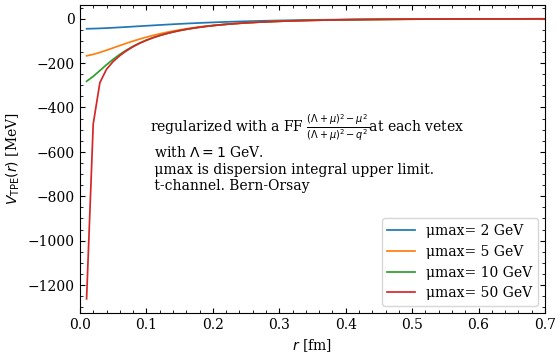

  2.211669 seconds (591.30 k allocations: 182.062 MiB, 2.18% gc time)


In [22]:
function plt_vσ(par1; rlow = 0.4)
    rfmv = rlow:0.01:0.7
    PyPlot.subplots(figsize=(6,4))
    PyPlot.grid(which="major", axis="both", alpha=0.25)
    PyPlot.plot(rfmv, vσsdp.(rfmv ./hbarc, Ref(par1),1,2.0), label = "μmax= 2 GeV")
    PyPlot.plot(rfmv, vσsdp.(rfmv ./hbarc, Ref(par1),1,5.0), label = "μmax= 5 GeV")
    PyPlot.plot(rfmv, vσsdp.(rfmv ./hbarc, Ref(par1),1,10.0), label = "μmax= 10 GeV")
    PyPlot.plot(rfmv, vσsdp.(rfmv ./hbarc, Ref(par1),1,50.0), label = "μmax= 50 GeV")
    PyPlot.annotate("regularized with a FF "*L"\frac{(\Lambda+\mu)^2-\mu^2}{(\Lambda+\mu)^2-q^2}"*"at each vetex"*"\n with "*L"\Lambda=1"
        *" GeV.\n μmax is dispersion integral upper limit.\n t-channel. Bern-Orsay",
        xy = (0.15,0.4),xycoords = "axes fraction")
    PyPlot.xlabel(L"r"*" [fm]"); PyPlot.ylabel(L"V_{\rm TPE}(r)"*" [MeV]")
    PyPlot.legend()
    PyPlot.minorticks_on(); PyPlot.tick_params(which="both",direction="in", right="on", top="on") 
    
    PyPlot.xlim(rfmv[1], rfmv[end]);
    PyPlot.savefig("potentials/Dipole-mu-var.pdf");
end
@time plt_vσ([C1,C2], rlow = 0.0)

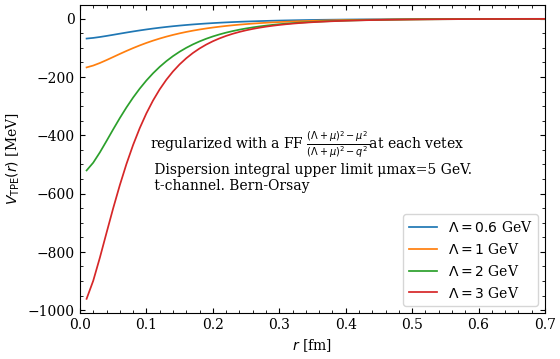

  2.302639 seconds (814.58 k allocations: 193.484 MiB, 1.46% gc time)


In [23]:
function plt_vσ(par1; rlow = 0.4)
    rfmv = rlow:0.01:0.7
    PyPlot.subplots(figsize=(6,4))
    PyPlot.grid(which="major", axis="both", alpha=0.25)
    PyPlot.plot(rfmv, vσsdp.(rfmv ./hbarc, Ref(par1),0.6,5.0), label = L"\Lambda = 0.6"*" GeV")
    PyPlot.plot(rfmv, vσsdp.(rfmv ./hbarc, Ref(par1),1,5.0), label = L"\Lambda = 1"*" GeV")
    PyPlot.plot(rfmv, vσsdp.(rfmv ./hbarc, Ref(par1),2,5.0), label = L"\Lambda = 2"*" GeV")
    PyPlot.plot(rfmv, vσsdp.(rfmv ./hbarc, Ref(par1),3,5.0), label = L"\Lambda = 3"*" GeV")
    PyPlot.annotate("regularized with a FF "*L"\frac{(\Lambda+\mu)^2-\mu^2}{(\Lambda+\mu)^2-q^2}"*"at each vetex"
        *"\n Dispersion integral upper limit μmax=5 GeV.\n t-channel. Bern-Orsay",
        xy = (0.15,0.4),xycoords = "axes fraction")
    PyPlot.xlabel(L"r"*" [fm]"); PyPlot.ylabel(L"V_{\rm TPE}(r)"*" [MeV]")
    PyPlot.legend()
    PyPlot.minorticks_on(); PyPlot.tick_params(which="both",direction="in", right="on", top="on") 
    PyPlot.xlim(rfmv[1], rfmv[end]);
    PyPlot.savefig("potentials/Dipole-Lambda-var.pdf");
end
@time plt_vσ([C1,C2], rlow = 0.0)

## Hard cutoff of the Fourier integral of $q$

In [9]:
# Fourier transform 
function fth(μ, r, Λ = 0.0)
    if Λ ≈ 0.0
        R = 0.8 /hbarc
        res = exp(-μ*r)/(4π*r) 
    else
        function inte(q) 
            return q*sin(q*r)/(μ^2+q^2) 
        end
        xft, wft = gauss(96, 0, Λ)
        res = quadgauss(inte, xft, wft) / (2π^2*r)
    end
    return res
end


# in units of MeV
function vσhs(r, par, Λ = 0.0,tmax=5.0;which=:BO)
    function vintegrand(w)
        s = w^2
        sqrt(s-4mπ^2) * (amp0(s, par,which=which))^2 * fth(w, r, Λ)
    end
    xx, ww = gauss(128*2, 2mπ+0.000001, tmax)
    res = -1/(8π^2)/(4mψp*mjψ) *  quadgauss(vintegrand, xx, ww) 
    return res * 1e3
end

vσhs (generic function with 3 methods)

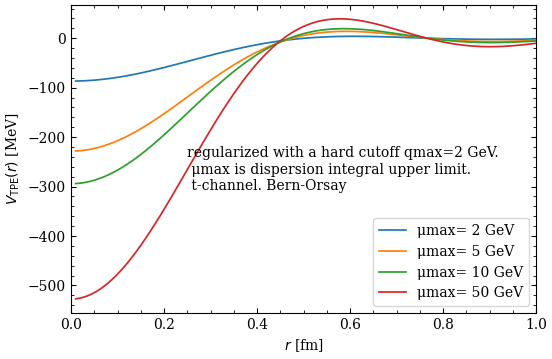

 42.087175 seconds (11.64 M allocations: 9.419 GiB, 3.05% gc time)


In [14]:
function plt_vσ(par1; rlow = 0.4)
    rfmv = rlow:0.01:1
    PyPlot.subplots(figsize=(6,4))
    PyPlot.grid(which="major", axis="both", alpha=0.25)
    PyPlot.plot(rfmv, vσhs.(rfmv ./hbarc, Ref(par1),2,2.0), label = "μmax= 2 GeV")
    PyPlot.plot(rfmv, vσhs.(rfmv ./hbarc, Ref(par1),2,5.0), label = "μmax= 5 GeV")
    PyPlot.plot(rfmv, vσhs.(rfmv ./hbarc, Ref(par1),2,10.0), label = "μmax= 10 GeV")
    PyPlot.plot(rfmv, vσhs.(rfmv ./hbarc, Ref(par1),2,50.0), label = "μmax= 50 GeV")
    PyPlot.annotate("regularized with a hard cutoff qmax=2 GeV."*
        "\n μmax is dispersion integral upper limit.\n t-channel. Bern-Orsay",
        xy = (0.25,0.4),xycoords = "axes fraction")
    PyPlot.xlabel(L"r"*" [fm]"); PyPlot.ylabel(L"V_{\rm TPE}(r)"*" [MeV]")
    PyPlot.legend()
    PyPlot.minorticks_on(); PyPlot.tick_params(which="both",direction="in", right="on", top="on") 
    
    PyPlot.xlim(rfmv[1], rfmv[end]);
    PyPlot.savefig("potentials/hard-mu-var.pdf");
end
@time plt_vσ([C1,C2], rlow = 0)

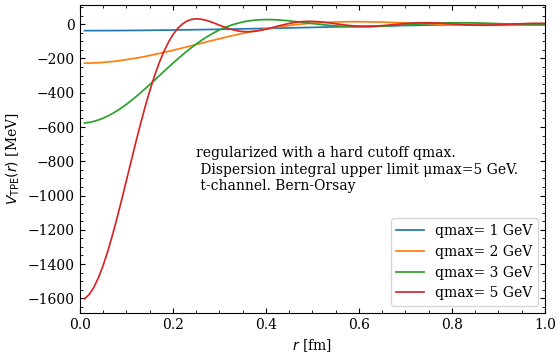

 41.503134 seconds (12.87 M allocations: 9.480 GiB, 3.11% gc time)


In [10]:
function plt_vσ(par1; rlow = 0.4)
    rfmv = rlow:0.01:1
    PyPlot.subplots(figsize=(6,4))
    PyPlot.grid(which="major", axis="both", alpha=0.25)
    PyPlot.plot(rfmv, vσhs.(rfmv ./hbarc, Ref(par1),1,5.0), label = "qmax= 1 GeV")
    PyPlot.plot(rfmv, vσhs.(rfmv ./hbarc, Ref(par1),2,5.0), label = "qmax= 2 GeV")
    PyPlot.plot(rfmv, vσhs.(rfmv ./hbarc, Ref(par1),3,5.0), label = "qmax= 3 GeV")
    PyPlot.plot(rfmv, vσhs.(rfmv ./hbarc, Ref(par1),5,5.0), label = "qmax= 5 GeV")
    PyPlot.annotate("regularized with a hard cutoff qmax."*
        "\n Dispersion integral upper limit μmax.\n t-channel. Bern-Orsay",
        xy = (0.25,0.4),xycoords = "axes fraction")
    PyPlot.xlabel(L"r"*" [fm]"); PyPlot.ylabel(L"V_{\rm TPE}(r)"*" [MeV]")
    PyPlot.legend()
    PyPlot.minorticks_on(); PyPlot.tick_params(which="both",direction="in", right="on", top="on") 
    
    PyPlot.xlim(rfmv[1], rfmv[end]);
    PyPlot.savefig("potentials/hard-q-var.pdf");
end
@time plt_vσ([C1,C2], rlow = 0)

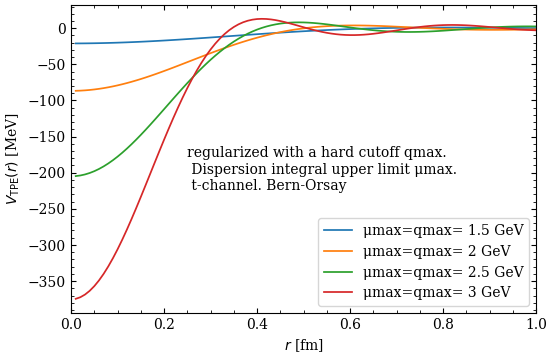

 40.068720 seconds (11.43 M allocations: 9.410 GiB, 2.99% gc time)


In [13]:
function plt_vσ(par1; rlow = 0.4)
    rfmv = rlow:0.01:1
    PyPlot.subplots(figsize=(6,4))
    PyPlot.grid(which="major", axis="both", alpha=0.25)
    PyPlot.plot(rfmv, vσhs.(rfmv ./hbarc, Ref(par1),1.5,1.5), label = "μmax=qmax= 1.5 GeV")
    PyPlot.plot(rfmv, vσhs.(rfmv ./hbarc, Ref(par1),2,2), label = "μmax=qmax= 2 GeV")
    PyPlot.plot(rfmv, vσhs.(rfmv ./hbarc, Ref(par1),2.5,2.5), label = "μmax=qmax= 2.5 GeV")
    PyPlot.plot(rfmv, vσhs.(rfmv ./hbarc, Ref(par1),3,3), label = "μmax=qmax= 3 GeV")
    PyPlot.annotate("regularized with a hard cutoff qmax."*
        "\n Dispersion integral upper limit μmax.\n t-channel. Bern-Orsay",
        xy = (0.25,0.4),xycoords = "axes fraction")
    PyPlot.xlabel(L"r"*" [fm]"); PyPlot.ylabel(L"V_{\rm TPE}(r)"*" [MeV]")
    PyPlot.legend()
    PyPlot.minorticks_on(); PyPlot.tick_params(which="both",direction="in", right="on", top="on") 
    
    PyPlot.xlim(rfmv[1], rfmv[end]);
    PyPlot.savefig("potentials/hard-q-mu-var.pdf");
end
@time plt_vσ([C1,C2], rlow = 0)

## Solving Schrödinger equation

In [32]:
using DifferentialEquations #, BoundaryValueDiffEq
using Roots

The Schrödinger equation for the radial wave function $R(r)$ of a central force:
\begin{equation}
    \frac1{r^2} \frac{d}{dr} \left(r^2 \frac{d R}{dr} \right) - \frac{l(l+1)}{r^2} R + 2\mu \left[ E - V(r) \right] R = 0
\end{equation}
With $R(r) = \chi(r)/r$, then 
\begin{equation}
    \frac{d^2\chi}{dr^2} + \left[2\mu (E - V) - \frac{l(l+1)}{r^2} \right] \chi = 0.
\end{equation}
If the potential is finite, then the wave function must be finite as well, meaning that $\chi(0) = 0$, which is satisfied even if $V(0)=\infty$.  

Asymptotic behavior in the vicinity of the origin:

Assuming $\lim_{r\to 0}V(r) r^2 = 0$, then the Schrödinger equation becomes $\frac{d}{dr} \left(r^2 \frac{d R}{dr} \right) - l(l+1) R  = 0$. Approximating $R(r)$ by a series and taking only the leading term $R(r)\propto r^s$, we get $s = l$ or $s=-(l+1)$. The latter can be excluded since it means $R(0)=\infty$. Then we get 
\begin{equation}
    \lim_{r\to 0} R_l(r) = {\rm const.}\times r^l \qquad {\rm or} \quad \lim_{r\to 0} \chi_l(r) {\rm const.}\times r^{l+1}.
\end{equation}
The boundary conditions for the $S$-wave $\chi(r)$ are:
\begin{equation}
    \chi_0(0) = 0, \qquad \chi_0'(0) = {\rm const.}
\end{equation}
Bound states are given by the solutions satisfying $\chi(\infty) = 0$.

Let's rewrite the equation for $\chi(r)$ into a system of two ODEs:
\begin{align}
    \frac{d\chi}{dr} &= f, \notag \\
    \frac{df}{dr} &= \left\{\frac{l(l+1)}{r^2} - 2\mu [E - V(r)] \right\} \chi .    
\end{align}
Boundary values: $\chi(0) = 0, f(0) =\, $const.

This can be solved using the `DifferentialEquations` and `BoundaryValueDiffEq` packages: 
\begin{equation}
    u[1]=\chi(r),\qquad u[2]=f(r) = \chi'(r).
\end{equation}
To avoid the $r=0$ singularity in the potential, the boundary value of the origin needs to be set to a tiny nonzero value.

### Solving for bound state

In [186]:
# u[1] = χ, u[2] = f
function seq_tpe!(du, u, p, r)
    μ = mjψ * mjψ/(mjψ + mjψ)
    e = p
    du[1] = u[2]
    # factor 3 to account for t, u channels and π⁰π⁰
    du[2] = -2μ * (e - 3v(r)) * u[1]
end

seq_tpe! (generic function with 2 methods)

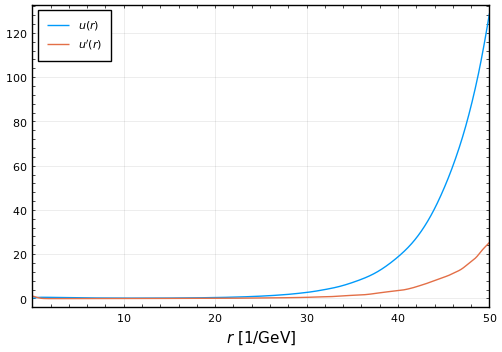

In [26]:
soltp = sol_tpei(-0.012,C1, C2, 1, 4,10)
plot(soltp, frame = :box, xlab = L"r"*" [1/GeV]", label = [L"u(r)" L"u'(r)"])

In [251]:
# solving the eigenvalue problem using the shooting method
function Eb(a,Λ)
rspan_up = 20.0;tmax=10;
xx=1e-8:0.03:rspan_up+1
yy=vσGau1s.(xx, Ref([C1,C2]),a, Λ, tmax)/1000
itp=LinearInterpolation(xx, yy)
v(r)=itp(r)
    
function seq_tpe!(du, u, p, r)
    μ = mjψ * mjψ/(mjψ + mjψ)
    e = p
    du[1] = u[2]
    # factor 3 to account for t, u channels and π⁰π⁰
    du[2] = -2μ * (e - 3v(r)) * u[1]
end
    
function sol_tpe(region; rspan_up = 20.0)
    u0 = [0.0; 1] # initial value for u and u'
    rspan = (1e-8, rspan_up)
    problem(e) = ODEProblem(seq_tpe!, u0, rspan, e)
    sol(e) = solve(problem(e))
    e_eigen = find_zero(e ->sol(e).u[end][1], region )
    solbs = sol(e_eigen)
    wfint = LinearInterpolation(solbs.t, hcat(solbs.u...)[1,:])
    norm = sqrt( quadgk(r -> wfint(r)^2, rspan..., rtol = 1e-5)[1] )
#     println("Bound state eigen-energy: ", e_eigen)
#     println("Normalization constant: ", norm)
    return e_eigen
end
plot(xx,yy)
end

Eb (generic function with 1 method)

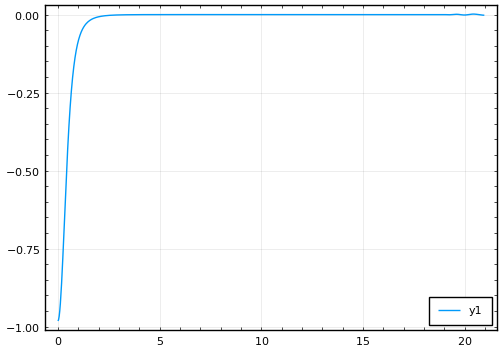

In [252]:
Eb(0.8,3.2)

In [237]:
Λs8=2.9:0.1:3.7;
Ebs8=[Eb(0.8,xxx) for xxx in Λs8]

Bound state eigen-energy: -0.0028161896288376935
Normalization constant: 1.3149155913478654
Bound state eigen-energy: -0.007825802388262248
Normalization constant: 1.04142972273812
Bound state eigen-energy: -0.014967363190406221
Normalization constant: 0.8561155331206443
Bound state eigen-energy: -0.024659608463890367
Normalization constant: 0.7238999441557474
Bound state eigen-energy: -0.03686345846418202
Normalization constant: 0.6284638311116174
Bound state eigen-energy: -0.0517804027433372
Normalization constant: 0.554615001288547
Bound state eigen-energy: -0.06978809254828076
Normalization constant: 0.49527716930408094
Bound state eigen-energy: -0.0903890768972464
Normalization constant: 0.5276416641566206
Bound state eigen-energy: -0.11416443991803549
Normalization constant: 0.9451115735796438


9-element Array{Float64,1}:
 -0.0028161896288376935
 -0.007825802388262248
 -0.014967363190406221
 -0.024659608463890367
 -0.03686345846418202
 -0.0517804027433372
 -0.06978809254828076
 -0.0903890768972464
 -0.11416443991803549

In [225]:
Λs=3.65:0.1:4.85;
Ebs=[Eb(1,xxx) for xxx in Λs]

Bound state eigen-energy: -0.0005161460286314811
Normalization constant: 1.6915813876188497
Bound state eigen-energy: -0.002687208547939357
Normalization constant: 1.4447017630283094
Bound state eigen-energy: -0.005544443045531699
Normalization constant: 1.24457775152292
Bound state eigen-energy: -0.009147536111633436
Normalization constant: 1.0858423584541643
Bound state eigen-energy: -0.013607225300086177
Normalization constant: 0.9612254481099641
Bound state eigen-energy: -0.018939246568514756
Normalization constant: 0.8637082512173903
Bound state eigen-energy: -0.025212193988337517
Normalization constant: 0.784592632986326
Bound state eigen-energy: -0.032424209953093475
Normalization constant: 0.7181283093529949
Bound state eigen-energy: -0.040732551713967835
Normalization constant: 0.6623060825115143
Bound state eigen-energy: -0.04989335139143391
Normalization constant: 0.6137825153880793
Bound state eigen-energy: -0.060237449398290226
Normalization constant: 0.5721810794032959
Bo

13-element Array{Float64,1}:
 -0.0005161460286314811
 -0.002687208547939357
 -0.005544443045531699
 -0.009147536111633436
 -0.013607225300086177
 -0.018939246568514756
 -0.025212193988337517
 -0.032424209953093475
 -0.040732551713967835
 -0.04989335139143391
 -0.060237449398290226
 -0.07143836111038238
 -0.08378226395080966

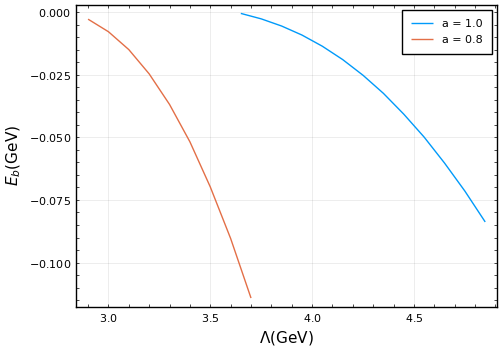

In [243]:
plot(Λs,Ebs,label="a = 1.0")
plot!(Λs8,Ebs8,label="a = 0.8")
xlabel!(L"\Lambda"*"(GeV)")
ylabel!(L"E_b"*"(GeV)")
savefig("Eb-Gau1.pdf")

Bound state eigen-energy: -0.01127412987672971
Normalization constant: 1.021383530604933
  1.944081 seconds (4.38 M allocations: 192.992 MiB, 1.87% gc time)


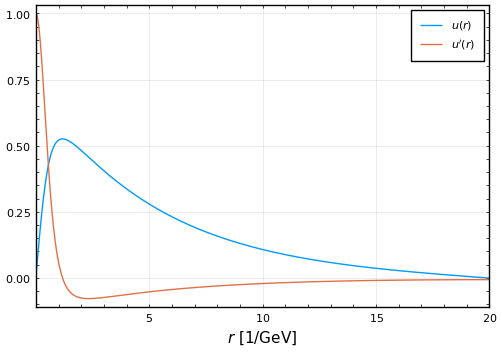

In [200]:
# with a cutoff of 2 GeV in the form factor
@time soltp = sol_tpe((-0.02, 0.))
plot(soltp, frame = :box, xlab = L"r"*" [1/GeV]", label = [L"u(r)" L"u'(r)"])